In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import warnings
import numpy as np
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from skbio.stats.composition import clr, alr
from skbio.diversity import alpha

import os
import sys 

MODULE_PATH = os.path.abspath('/storage/zkarwowska/predicting-microbiome-in-time/data-processing/data-preparation/') 
if MODULE_PATH not in sys.path:
    sys.path.append(MODULE_PATH)
    
from processing import MicrobiomeDataPreprocessing, CLRTransformer, MicrobiomeTraintestSplit
from interpolation import Interpolation

### prepare input data

In [2]:
taxonomy = pd.read_csv('/storage/zkarwowska/predicting-microbiome-in-time/data-processing/assign-taxonomy/taxonomy.csv', index_col=[0])
taxonomy.index.name = 'feature'

In [3]:
INPUT_FILE = '/storage/zkarwowska/microbiome-interactions/datasets/processed/ready_datasets_no_rarefaction/male_assigned_sample_names.csv'

DF = pd.read_csv(INPUT_FILE, index_col = [0])
DF.index  = DF.index.astype(int)

#interpolate using pchip
interpolator = Interpolation()
INTERPOLATED_DF = interpolator.interpolate_pchip(DF) 

INTERPOLATED_PSEUDO = INTERPOLATED_DF +1e-9

#INTERPOLATED_PRC = INTERPOLATED_PSEUDO.div(INTERPOLATED_PSEUDO.sum(axis=1), axis=0) + 1e-9

#change to ratio
CLR_DF =  pd.DataFrame(clr(INTERPOLATED_PSEUDO), columns = INTERPOLATED_PSEUDO.columns)

#filter rare bacteria 
processing = MicrobiomeDataPreprocessing()
KEEP_COLUMNS = processing.filter_rare_features(INTERPOLATED_DF, treshold_perc=0.7).columns

FILTERED_CLR_DF = CLR_DF[KEEP_COLUMNS]
FILTERED_COUNT_DF = INTERPOLATED_PSEUDO[KEEP_COLUMNS]

#assign date to index
METADATA_FILE = '/storage/zkarwowska/microbiome-interactions/datasets/processed/qiita_550/raw_data/550_metadata.txt'
metadata = pd.read_csv(METADATA_FILE, sep = '\t')
metadata = metadata[(metadata['body_product'] == 'UBERON:feces') & \
                    (metadata['sex'] == 'male') & \
                    (metadata['mislabeled']==False)].sort_values(by = 'days_since_experiment_start')

dates = pd.date_range(start=metadata['collection_timestamp'].min(), end=metadata['collection_timestamp'].max(), freq='D')
FILTERED_CLR_DF.index = dates

## create features to plot on PCA

In [4]:
time_df = pd.DataFrame(FILTERED_CLR_DF.index, columns = ['date'])
time_df['month'], time_df['YEAR'] = FILTERED_CLR_DF.index.month.astype(str), FILTERED_CLR_DF.index.year

def make_new_col(row):
    if row['month'] in (['12', '1', '2']):
        val = 'winter'
    elif row['month'] in (['3', '4', '5']):
        val = 'spring'
    elif row['month'] in (['6', '7', '8']):
        val = 'summer'
    elif row['month'] in (['9', '10', '11']):
        val = 'autumn'
                           
    return val

def calculate_shannon(df):
    
    SHANNON_DIVERSITY = []
    for i in range(len(df.index)):

        shannon = alpha.shannon(df.iloc[i])
        SHANNON_DIVERSITY.append(shannon)
    return SHANNON_DIVERSITY

def calculate_n_features(df):
    
    OBSERVED_OTUS = []
    for i in range(len(df.index)):

        obs_otus = alpha.observed_otus(df.iloc[i])
        OBSERVED_OTUS.append(obs_otus)
        
    return OBSERVED_OTUS
    
time_df['No FEATURES'] = calculate_n_features(INTERPOLATED_DF)
time_df['SHANNON'] = calculate_shannon(INTERPOLATED_DF)
time_df['SEASON'] = time_df.apply(make_new_col, axis=1)

## PCA ON ALL TIME SERIE - how does microbiome change throughout the time serie

In [5]:
scaler = StandardScaler()
scaled_X = scaler.fit_transform(FILTERED_CLR_DF)
pca = PCA()
x_new = pca.fit_transform(scaled_X)
score = x_new[:,0:2]
coeff = np.transpose(pca.components_[0:2, :])
hue_variable = time_df['SEASON'] 
style_variable = time_df['YEAR'] 

xs = score[:,0]
ys = score[:,1]
n = len(FILTERED_CLR_DF.columns)
scaled_xs = xs * (1.0/(xs.max() - xs.min()))
scaled_ys = ys * (1.0/(xs.max() - xs.min()))

coeff_df = pd.DataFrame(coeff, columns = ['X', 'Y'])
coeff_df['feature'] = FILTERED_CLR_DF.columns
merged_coeff_taxonomy = pd.merge(coeff_df, taxonomy, on="feature")
merged_coeff_taxonomy[['k', 'p', 'c', 'o', 'f', 'g', 's']] = merged_coeff_taxonomy.Taxon.str.split('; ', expand=True)

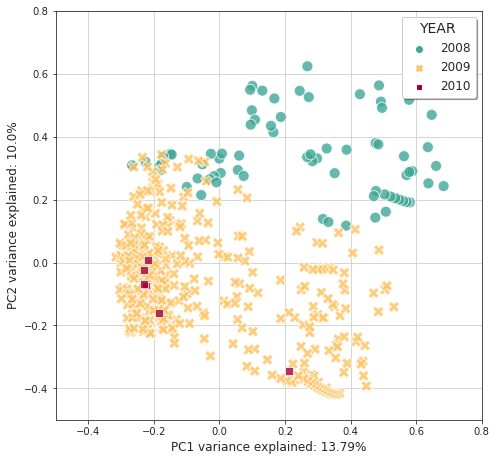

In [10]:
labels = None
hue_variable = time_df['YEAR']

sns.set_style('ticks')
fig = plt.figure(figsize=(7, 7))
ax = sns.scatterplot(x = scaled_xs,
                     y = scaled_ys,
                     edgecolor = 'w',
                     alpha = .8,
                     hue = hue_variable,
                     style=hue_variable,
                     palette=['#3FA796', '#FEC260', '#A10035'],
                     s=120)

plt.rcParams['legend.title_fontsize'] = 14
ax.legend(loc='best',  fancybox=True,shadow=True, title="YEAR", fontsize=12)

plt.xlim(-0.5,.8)
plt.ylim(-0.5,.8)
plt.xlabel("PC1 variance explained: {}%".format(np.round(pca.explained_variance_ratio_[0]*100, 2)), fontsize = 12)
plt.ylabel("PC2 variance explained: {}%".format(np.round(pca.explained_variance_ratio_[1]*100), 2), fontsize = 12)
plt.grid()
plt.tight_layout()
plt.subplots_adjust(top=.9)
plt.savefig('MALE_OTU_PCA_YEAR_norm_1e-5.png')
plt.show()

## PCA ONLY ON 2009 - how different bacteria inside one family behave

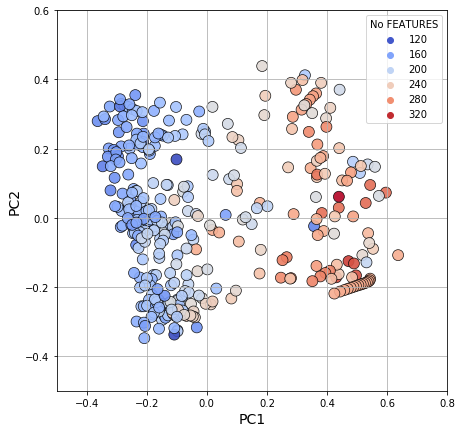

In [6]:
one_year_data= FILTERED_CLR_DF[FILTERED_CLR_DF.index.year == 2009]

scaler = StandardScaler()
scaled_X = scaler.fit_transform(one_year_data)
pca = PCA()
x_new = pca.fit_transform(scaled_X)
score = x_new[:,0:2]
coeff = np.transpose(pca.components_[0:2, :])
hue_variable = time_df[time_df.set_index(time_df.date).index.year == 2009]['SEASON'] 
style_variable = time_df[time_df.set_index(time_df.date).index.year == 2009]['YEAR'] 
mean_variable = one_year_data.T.mean().astype(int)
shannon_variable = time_df[time_df.set_index(time_df.date).index.year == 2009]['No FEATURES'] 
labels = None

xs = score[:,0]
ys = score[:,1]
n = len(FILTERED_CLR_DF.columns)
scaled_xs = xs * (1.0/(xs.max() - xs.min()))
scaled_ys = ys * (1.0/(xs.max() - xs.min()))

coeff_df = pd.DataFrame(coeff, columns = ['X', 'Y'])
coeff_df['feature'] = FILTERED_CLR_DF.columns

merged_coeff_taxonomy = pd.merge(coeff_df, taxonomy, on="feature")
merged_coeff_taxonomy[['k', 'p', 'c', 'o', 'f', 'g', 's']] = merged_coeff_taxonomy.Taxon.str.split('; ', expand=True)

fig = plt.figure(figsize=(7, 7))
sns.scatterplot(x = scaled_xs,
                y = scaled_ys,
                alpha = .9,
                edgecolor = 'k',
                linewidth=.7, 
                hue = shannon_variable,
                s=120,
                palette='coolwarm')

plt.xlim(-0.5,0.8)
plt.ylim(-0.5,0.6)
plt.grid()
plt.xlabel("PC1", size=14)
plt.ylabel("PC2", size=14)
plt.savefig('MALE_OTU_PCA12_2009.png')

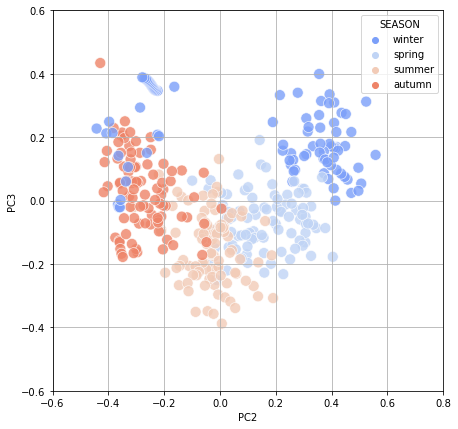

In [7]:
seasonal_colors = ['#6DC9F7', '#91D347', '#E82929', 'orange']
seasons = ['winter', 'spring','summer', 'autumn']     

seasonal_palette = dict(zip(seasons, seasonal_colors))

one_year_data= FILTERED_CLR_DF[FILTERED_CLR_DF.index.year == 2009]

scaler = StandardScaler()
scaled_X = scaler.fit_transform(one_year_data)
pca = PCA()
x_new = pca.fit_transform(scaled_X)
score = x_new[:,1:3]
coeff = np.transpose(pca.components_[1:3, :])

labels = None

xs = score[:,0]
ys = score[:,1]
n = len(FILTERED_CLR_DF.columns)
scaled_xs = xs * (1.0/(xs.max() - xs.min()))
scaled_ys = ys * (1.0/(xs.max() - xs.min()))

coeff_df = pd.DataFrame(coeff, columns = ['X', 'Y'])
coeff_df['feature'] = FILTERED_CLR_DF.columns

merged_coeff_taxonomy = pd.merge(coeff_df, taxonomy, on="feature")
merged_coeff_taxonomy[['k', 'p', 'c', 'o', 'f', 'g', 's']] = merged_coeff_taxonomy.Taxon.str.split('; ', expand=True)

fig = plt.figure(figsize=(7, 7))
sns.scatterplot(x = scaled_xs,
                y = scaled_ys,
                alpha = .8,
                edgecolor = 'white',
                hue = hue_variable,
                linewidth=.7,
                s=120,
               palette = 'coolwarm')

plt.xlim(-0.6,0.8)
plt.ylim(-0.6,0.6)
plt.grid()
plt.xlabel("PC2")
plt.ylabel("PC3")
plt.savefig('MALE_OTU_PCA23_2009.png')

## plot explained variance ratio

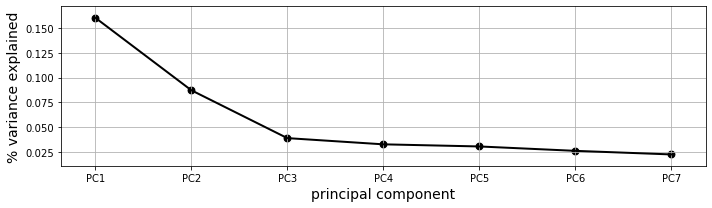

In [8]:
fig = plt.figure(figsize=(10, 3))
sns.lineplot(x = ['PC' + str(i) for i in range(1, 8)],
            y=pca.explained_variance_ratio_[:7],
            color='k',
            linewidth = 2, 
            linestyle='-')
sns.scatterplot(x = ['PC' + str(i) for i in range(1, 8)],
                y=pca.explained_variance_ratio_[:7],
                color='k',
                linewidth = 1, 
                s = 80, 
                linestyle='-')
plt.grid()
plt.xlabel('principal component', size=14)
plt.ylabel('% variance explained', size=14)
plt.tight_layout()
plt.savefig('variance_explained.png')

## PCA on family: biplot and covariance matrix

In [9]:
LENGTH = []
for i in range(len(coeff_df.index)):
    
    vector_length = np.linalg.norm(merged_coeff_taxonomy.iloc[i][["X", "Y"]])
    LENGTH.append(vector_length)
    
merged_coeff_taxonomy['vector_length'] = LENGTH

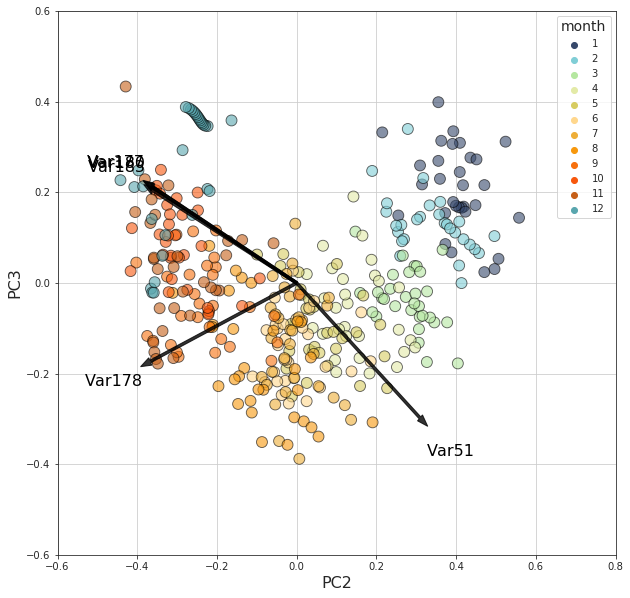

In [99]:
cmap = ['#36486b', '#80ced6', '#b5e7a0', '#e3eaa7','#D7CC61','#FFD78D','#EEAE38','#F7980D','#F7700D','#F7570D','#C65F18','#59A6AE']
fig = plt.figure(figsize=(10, 10))
sns.scatterplot(x = scaled_xs,
                y = scaled_ys,
                alpha = .6,
                edgecolor = 'black',
                hue = time_df[time_df.YEAR == 2009].month,
                linewidth=.9,
                s=120,
                palette = cmap)

plt.xlim(-0.6,0.8)
plt.ylim(-0.6,0.6)
plt.grid()
plt.xlabel("PC2", fontsize=16)
plt.ylabel("PC3", fontsize=16)

for i in merged_coeff_taxonomy.sort_values(by='vector_length').tail(5).index:
    plt.arrow(0, 0, coeff[i,0]*2, coeff[i,1]*2,  alpha = .8, color='k', width=.006, shape='full')
    if labels is None:
        plt.text(coeff[i,0]*2.5, coeff[i,1]*2.5, "Var"+str(i), size=16, color = 'black', ha = 'center', va = 'center')
plt.savefig('loadings.png')

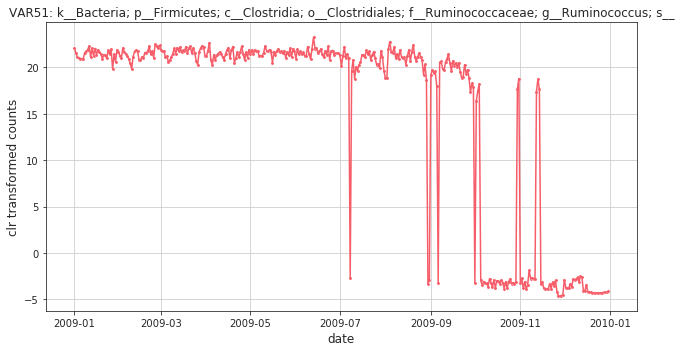

In [118]:
import datetime as dt

col1 = 'TACGTAGGGGGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGAGAAGCAAGTCAGTGGTGAAAACGATGGGCTTAACTCATCGACTG'
col2 = 'TACGTAGGTGGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGCAGGCGGGGAGCCAAGTCAGCTGTGAAAACTACGGGCTTAACCTGTAGACTG'
col3 = 'TACGTAGGGGGCGAGCGTTGTCCGGAATGATTGGGCGTAAAGGGCGCGTAGGCGGCCTGCTAAGTCTGGAGTGAAAGTCCTGCTTTCAAGGTGGGAATTG'

fig = plt.figure(figsize=(10, 5))
sns.lineplot(x = one_year_data.index,
             y=one_year_data[col1].values,
            color='#F65D69')
sns.scatterplot(x = one_year_data.index,
             y=one_year_data[col1].values,
            color='#F65D69', s=10)

plt.grid()
plt.title('VAR51: k__Bacteria; p__Firmicutes; c__Clostridia; o__Clostridiales; f__Ruminococcaceae; g__Ruminococcus; s__', size=12)
plt.xlabel('date', size=12)
plt.ylabel('clr transformed counts', size=12)

plt.tight_layout()
plt.savefig('plots/var51.png')